In [1]:
import uproot
import subprocess
import awkward as ak
import awkward
import numba
import numpy as np
import numpy
import hist
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import mplhep as hep
plt.style.use(hep.style.CMS)
from collections import defaultdict
import matplotlib.ticker as mtick
import particle

In [2]:
ar_raw = uproot.concatenate([f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/Categorization/bul_2018_ZZ_v12/tt_sl/cat_ZZ_EC90_boosted_bb_boostedTau/prod_241213c/data_{i}.root:Events" for i in range(5)])

In [3]:
import urllib.parse
import copy
def quote(x):
    return urllib.parse.quote(x, safe="")
def unquote(x):
    return urllib.parse.unquote(x)
def concat(*keys):
    return quote(",".join(unquote(k if k is not None else "") for k in keys))
def ensure_array(arraylike):
    if isinstance(arraylike, (awkward.contents.Content, awkward.Array)):
        return awkward.to_numpy(arraylike)
    elif isinstance(arraylike, awkward.index.Index):
        return arraylike.data
    else:
        return numpy.asarray(arraylike)


def counts2offsets(counts):
    """Cumulative sum of counts

    Signature: counts,!counts2offsets
    Outputs an array with length one larger than input
    """
    #counts = ensure_array(stack.pop())
    offsets = numpy.empty(len(counts) + 1, dtype=numpy.int64)
    offsets[0] = 0
    numpy.cumsum(counts, out=offsets[1:])
    return offsets


def local2global(stack):
    """Turn jagged local index into global index

    Signature: index,target_offsets,!local2global
    Outputs a content array with same shape as index content
    """
    target_offsets = ensure_array(stack.pop())
    index = stack.pop()
    index = index.mask[index >= 0] + target_offsets[:-1]
    index = index.mask[index < target_offsets[1:]]
    out = ensure_array(awkward.flatten(awkward.fill_none(index, -1), axis=None))
    if out.dtype != numpy.int64:
        raise RuntimeError
    stack.append(out)

@numba.njit
def _distinctParent_kernel(allpart_parent, allpart_pdg):
    out = numpy.empty(len(allpart_pdg), dtype=numpy.int64)
    for i in range(len(allpart_pdg)):
        parent = allpart_parent[i]
        if parent < 0:
            out[i] = -1
            continue
        thispdg = allpart_pdg[i]
        while parent >= 0 and allpart_pdg[parent] == thispdg:
            if parent >= len(allpart_pdg):
                raise RuntimeError("parent index beyond length of array!")
            parent = allpart_parent[parent]
        out[i] = parent
    return out


def distinctParent(stack):
    """Compute first parent with distinct PDG id

    Signature: globalparents,globalpdgs,!distinctParent
    Expects global indexes, flat arrays, which should be same length
    """
    pdg = stack.pop()
    parents = stack.pop()
    stack.append(_distinctParent_kernel(awkward.Array(parents), awkward.Array(pdg)))



In [4]:
def zip_prefix(ar, prefix, branches=None, with_name=None, additional_branches=dict()):
    if branches:
        return ak.zip({b : ar[prefix+"_"+b] for b in branches}|additional_branches, with_name=with_name)
    else:
        return ak.zip({f.split("_", 1)[1] : ar[f] for f in ar.fields if f.startswith(prefix+"_")}, with_name=with_name)


In [5]:
@ak.mixin_class(ak.behavior)
class GenPartArray:
    pass
    # @property
    # def idx(self):
    #     return ak.local_index(self)

def genPart_parent(genpart, genparts):
    parent_idx = genpart.genPartIdxMother
    while parent_idx >= 0 and genparts[parent_idx].pdgId == genpart.pdgId:
        if parent_idx >= len(genparts):
            raise RuntimeError("parent index beyond length of array!")
        parent_idx = genparts.genPartIdxMother[parent_idx]
    return genparts[parent_idx]

@ak.mixin_class(ak.behavior)
class GenPart:
    statusFlags_doc = {0 : "isPrompt", 1 : "isDecayedLeptonHadron", 2 : "isTauDecayProduct", 3 : "isPromptTauDecayProduct", 4 : "isDirectTauDecayProduct", 5 : "isDirectPromptTauDecayProduct", 6 : "isDirectHadronDecayProduct", 7 : "isHardProcess", 8 : "fromHardProcess", 9 : "isHardProcessTauDecayProduct", 10 : "isDirectHardProcessTauDecayProduct", 11 : "fromHardProcessBeforeFSR", 12 : "isFirstCopy", 13 : "isLastCopy", 14 : "isLastCopyBeforeFSR"}
    statusFlags_name_map = {v: k for k, v in statusFlags_doc.items()}
    def readStatusFlagsBits(self):
        s = ""
        for bitn in self.statusFlags_doc.keys():
            is_bit_set = (self.statusFlags & (1 << bitn)) != 0
            if is_bit_set:
                s += self.statusFlags_doc[bitn] + ", "
        return s

    def hasFlags(self, flagName):
        flag_nb = self.statusFlags_name_map[flagName]
        mask = 0
        mask |= 1 << flag_nb
        return (self.statusFlags & mask) == mask


In [13]:
events = ak.zip({
    "Jet":zip_prefix(ar_raw, "Jet", ["pt", "eta", "phi", "mass"]),
    "FatJet":zip_prefix(ar_raw, "FatJet", ["pt", "eta", "phi", "mass", "msoftdrop", "particleNetLegacy_Xbb", "particleNetLegacy_QCD"]),
    "boostedTau":zip_prefix(ar_raw, "Jet", ["pt", "eta", "phi", "mass"]),
    "GenPart":ak.with_parameter(
        zip_prefix(ar_raw, "GenPart", ["pt", "eta", "phi", "pdgId", "genPartIdxMother", "statusFlags"], with_name="GenPart", additional_branches=dict(idx=ak.local_index(ar_raw.GenPart_pt))),
        "__list__", "GenPartArray")
    }
, depth_limit=1)
scalar_branches = ["nGenPart", "pairType"]
for branch in scalar_branches:
    events[branch] = ar_raw[branch]
evt = events[0]
evt = ak.Record({
    "Jet":evt.Jet, "FatJet":evt.FatJet, "boostedTau":evt.boostedTau,
    "GenPart":ak.zip({f:evt.GenPart[f] for f in evt.GenPart.fields} | {
        "parentPdgId":ak.Array(genPart_parent(gp, evt.GenPart).pdgId for gp in evt.GenPart)
    },  with_name="GenPart"),
    **{b : evt[b] for b in scalar_branches}
    })
evt

<Record {Jet: [{...}, ...], FatJet: ..., ...} type='{Jet: 4 * {pt: float32,...'>

In [7]:
jet_filter = evt.Jet.pt > 25
selected_jets = evt.Jet[jet_filter]
fatjet_filter = evt.FatJet.pt>250
selected_fatjets = evt.FatJet[fatjet_filter]

# get genParticles
selected_genpart = evt.GenPart

genpart_filter_plotting = (
    (
        (
            (np.abs(evt.GenPart.pdgId)<=5) & # quark (not top)
            (
                ((np.abs(evt.GenPart.parentPdgId)>=22)&(np.abs(evt.GenPart.parentPdgId)<=25)) | #decaying from gauge boson
                (np.abs(evt.GenPart.parentPdgId)==6) # decaying from top
            )
        ) |
        (np.abs(evt.GenPart.pdgId)==15) | # tau
        ((np.abs(evt.GenPart.pdgId)>=23)&(np.abs(evt.GenPart.pdgId)<=25) ) | # gauge boson (not photon)
        (np.abs(evt.GenPart.pdgId)==6) # top quark
    ) &
    (evt.GenPart.hasFlags("isLastCopy")) &
    (np.abs(evt.GenPart.pdgId)>0))
genpart_filter_plotting

<Array [True, True, False, False, ..., False, False, False] type='39 * bool'>

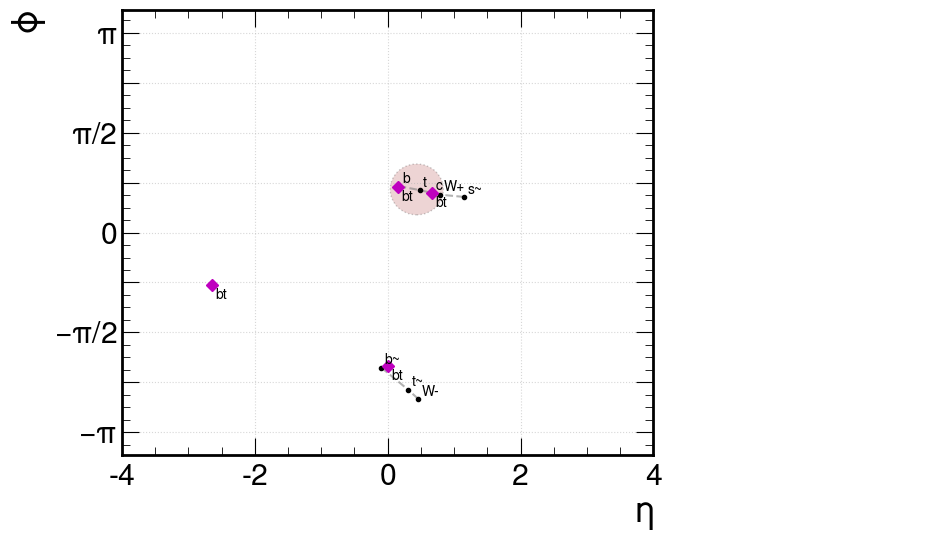

In [17]:
fig,axs = plt.subplots(1,2,figsize=(10,6),gridspec_kw={'width_ratios': [2.3, 1]})

# get eta and phi t/W and their quark daughters
genp_plot = evt.GenPart[genpart_filter_plotting]
genpart_eta = genp_plot.eta[(np.abs(genp_plot.eta)<4)
                                            & (np.abs(genp_plot.phi)<=np.pi)]
genpart_phi = genp_plot.phi[(np.abs(genp_plot.eta)<4)
                                            & (np.abs(genp_plot.phi)<=np.pi)]



#avg_jet_eta = np.average(selected_jets_region[iEvt].eta)
avg_jet_eta = 0

# print particle name and draw lines to parents
for i in range(len(genp_plot)):
    gen_p = genp_plot[i]
    # if in range
    if np.abs(genp_plot[i].eta)<avg_jet_eta+4:

        # print text
        axs[0].text(genp_plot[i].eta+0.05,
                    genp_plot[i].phi+0.05,
                    f"{particle.Particle.from_pdgid(genp_plot[i].pdgId).name}",
                    fontsize=10)

        # if parent exists
        if genp_plot[i].parentPdgId != 0 and not genp_plot[i].genPartIdxMother==-1:
            gen_parent = genPart_parent(gen_p, evt.GenPart)
            # if in range
            if np.abs(gen_parent.eta)<avg_jet_eta+4:

                particle_parent_pair = np.array([genp_plot[i], gen_parent])

                distances = [np.sqrt((particle_parent_pair[0].eta-particle_parent_pair[1].eta)**2 +
                                        (particle_parent_pair[0].phi-particle_parent_pair[1].phi)**2),
                                np.sqrt((particle_parent_pair[0].eta-particle_parent_pair[1].eta)**2 +
                                        (particle_parent_pair[0].phi-particle_parent_pair[1].phi+2*np.pi)**2),
                                np.sqrt((particle_parent_pair[0].eta-particle_parent_pair[1].eta)**2 +
                                        (particle_parent_pair[0].phi-particle_parent_pair[1].phi-2*np.pi)**2)]

                # draw line between particle and parent
                if np.argmin(distances)==0:
                    axs[0].plot([particle_parent_pair[0].eta, particle_parent_pair[1].eta],
                                [particle_parent_pair[0].phi, particle_parent_pair[1].phi],
                                marker=None, linestyle='dashed', color='grey', alpha=0.6)
                else:
                    higher_particle = particle_parent_pair[np.argmax([particle_parent_pair[0].phi,particle_parent_pair[1].phi])]
                    lower_particle = particle_parent_pair[np.argmin([particle_parent_pair[0].phi,particle_parent_pair[1].phi])]

                    axs[0].plot([higher_particle.eta, lower_particle.eta],
                                [higher_particle.phi, lower_particle.phi+2*np.pi],
                                marker=None, linestyle='dashed', color='grey', alpha=0.6)
                    axs[0].plot([higher_particle.eta, lower_particle.eta],
                                [higher_particle.phi-2*np.pi, lower_particle.phi],
                                marker=None, linestyle='dashed', color='grey', alpha=0.6)

# plot t/W and their daughter quarks
axs[0].plot(genpart_eta, genpart_phi, 'k.')
axs[0].plot(genpart_eta, genpart_phi-2*np.pi, 'k.')
axs[0].plot(genpart_eta, genpart_phi+2*np.pi, 'k.')

# # print particle name for all quarks
# for i in range(len(all_quarks[iEvt])):

#     # if in range
#     if ((np.abs(all_quarks[iEvt][i].eta)<4) & (np.abs(all_quarks[iEvt][i].phi)<=np.pi)):

#         # print text
#         axs[0].text(all_quarks[iEvt][i].eta+0.05,
#                     all_quarks[iEvt][i].phi+0.05,
#                     f"{particle.Particle.from_pdgid(all_quarks[iEvt][i].pdgId).name}",
#                     fontsize=10)

# # grab quark eta and phi
# quark_eta = all_quarks[iEvt].eta[(np.abs(all_quarks[iEvt].eta)<4) & (np.abs(all_quarks[iEvt].phi)<=np.pi)]
# quark_phi = all_quarks[iEvt].phi[(np.abs(all_quarks[iEvt].eta)<4) & (np.abs(all_quarks[iEvt].phi)<=np.pi)]

# # plot quarks
# axs[0].plot(quark_eta, quark_phi, 'k.',markersize=0.8)
# axs[0].plot(quark_eta, quark_phi-2*np.pi, 'k.',markersize=0.8)
# axs[0].plot(quark_eta, quark_phi+2*np.pi, 'k.',markersize=0.8)

jetcolors = ['brown','red','orange',
             'darkgreen','teal','dodgerblue',
             'blue','blueviolet','purple','deeppink']

order_elements = []
for i,jet in enumerate(selected_fatjets):
    # create circle centered around jet center with R=0.4
    circle = plt.Circle((jet.eta, jet.phi), 0.4, facecolor=jetcolors[i], edgecolor = 'k', linestyle='dotted', alpha=0.2)
    axs[0].add_patch(circle)

    if jet.phi>np.pi-0.4:
        circle2 = plt.Circle((jet.eta, jet.phi-2*np.pi), 0.4, facecolor=jetcolors[i], edgecolor = 'k', linestyle='dotted', alpha=0.2)
        axs[0].add_patch(circle2)
    elif jet.phi<-np.pi+0.4:
        circle2 = plt.Circle((jet.eta, jet.phi+2*np.pi), 0.4, facecolor=jetcolors[i], edgecolor = 'k', linestyle='dotted', alpha=0.2)
        axs[0].add_patch(circle2)


    # # add border if b-tagged
    # if jet.btagCSVV2>B_TAG_THRESHOLD:
    #     circle = plt.Circle((jet.eta, jet.phi), 0.4, facecolor=None, edgecolor = 'k',
    #                         linestyle='solid', fill=False)
    #     if jet.phi>np.pi-0.4:
    #         circle2 = plt.Circle((jet.eta, jet.phi-2*np.pi), 0.4, facecolor=None, edgecolor = 'k',
    #                                 linestyle='solid', fill=False)
    #         axs[0].add_patch(circle2)
    #     elif jet.phi<-np.pi+0.4:
    #         circle2 = plt.Circle((jet.eta, jet.phi+2*np.pi), 0.4, facecolor=None, edgecolor = 'k',
    #                                 linestyle='solid', fill=False)
    #         axs[0].add_patch(circle2)
    #     else:
    #         circle2 = None

    #     axs[0].add_patch(circle)

    # if nearest_genpart[iEvt][i] is not None:
    #     axs[0].plot(nearest_genpart[iEvt][i].eta,nearest_genpart[iEvt][i].phi,'o',color=jetcolors[i])
    #     axs[0].text(nearest_genpart[iEvt][i].eta+0.05,nearest_genpart[iEvt][i].phi+0.05,
    #                 f"{particle.Particle.from_pdgid(nearest_genpart[iEvt][i].pdgId).name}",
    #                 fontsize=10)
    #     axs[0].plot(nearest_genpart[iEvt][i].eta,nearest_genpart[iEvt][i].phi-2*np.pi,'o',color=jetcolors[i])
    #     axs[0].plot(nearest_genpart[iEvt][i].eta,nearest_genpart[iEvt][i].phi+2*np.pi,'o',color=jetcolors[i])

    #     if nearest_parent[iEvt][i] is not None:
    #         axs[0].plot(nearest_parent[iEvt][i].eta,nearest_parent[iEvt][i].phi,'*',color=jetcolors[i])
    #         axs[0].text(nearest_parent[iEvt][i].eta+0.05,nearest_parent[iEvt][i].phi+0.05,
    #                     f"{particle.Particle.from_pdgid(nearest_parent[iEvt][i].pdgId).name}",
    #                     fontsize=10)
    #         axs[0].plot(nearest_parent[iEvt][i].eta,nearest_parent[iEvt][i].phi-2*np.pi,'*',color=jetcolors[i])
    #        axs[0].plot(nearest_parent[iEvt][i].eta,nearest_parent[iEvt][i].phi+2*np.pi,'*',color=jetcolors[i])

    # add jet color info for legend
    order_elements.append(Patch(facecolor=jetcolors[i], edgecolor=jetcolors[i],label=''))

# plot electrons
axs[0].plot(evt.boostedTau.eta, evt.boostedTau.phi, 'mD')
for i, boostedTau in enumerate(evt.boostedTau):
    axs[0].text(boostedTau.eta+0.05, boostedTau.phi-0.05, "bt", fontsize=10, va="top")

# # plot muons
# axs[0].plot(selected_muons[iEvt].eta, selected_muons[iEvt].phi, 'mD')
# for i in range(len(selected_muons[iEvt])):
#     axs[0].text(selected_muons[iEvt][i].eta+0.05, selected_muons[iEvt][i].phi+0.05, "$\mu$", fontsize=10)


# # legend for jet order
# legend1 = plt.legend(handles=order_elements,
#                         title="Jet Order",
#                         loc='upper left')

# # legend for particles
# particle_legend_elements = [Line2D([0], [0], marker='.', color='k', label='Closest Daughter of t/W',
#                                     markersize=10, linestyle='None'),
#                             Line2D([0], [0], marker='*', color='k', label='Parent t/W',
#                                     markersize=10, linestyle='None'),
#                             Line2D([0], [0], marker='.', color='k', label='Other Quarks',
#                                     markersize=5, linestyle='None'),
#                             Line2D([0], [0], marker='D', color='m', label='Leptons',
#                                     markersize=10, linestyle='None'),
#                             Line2D([0], [0], marker=None, color='gray', label='Parentage',
#                                     linestyle='dashed')]

# legend2 = plt.legend(handles=particle_legend_elements,
#                         title="Particle Key",
#                         loc='lower left')

# # legend for jets
# jet_legend_elements = [Line2D([0], [0], marker=None, color='k', label=f'b-tagged (>={B_TAG_THRESHOLD})',
#                                 linestyle='solid',alpha=1.0),
#                         Line2D([0], [0], marker=None, color='k', label='not b-tagged',
#                                 linestyle='dotted',alpha=0.5)]

# legend3 = plt.legend(handles=jet_legend_elements,
#                         title="Jet Key",
#                         loc='center left')

# # marks pi and -pi on plot
# axs[0].hlines([-np.pi, np.pi], -10, 10, color='darkgray', alpha=1.0, linewidth=1)

# # add legends to plot
# axs[1].add_artist(legend1)
# axs[1].add_artist(legend2)
# axs[1].add_artist(legend3)

# # shade areas outside phi=(-pi,pi)
# axs[0].fill_between([-10,10],np.pi,np.pi+1,color='lightgray',alpha=0.85)
# axs[0].fill_between([-10,10],-1-np.pi,-np.pi,color='lightgray',alpha=0.85)

# plotting limits
axs[0].set_xlim([avg_jet_eta-4,avg_jet_eta+4])
axs[0].set_ylim([-3.5,3.5])

# set axis labels
axs[0].set_xlabel("$\eta$")
axs[0].set_ylabel("$\phi$")

# phi axis in units of pi
# axs[0].yaxis.set_major_formatter(FormatStrFormatter('%g $\pi$'))
# axs[0].yaxis.set_major_locator(MultipleLocator(base=np.pi))
axs[0].set_yticks([-np.pi,-3*np.pi/4,-np.pi/2,-np.pi/4,0,np.pi/4,np.pi/2,3*np.pi/4,np.pi])
axs[0].set_yticklabels(["$-\pi$","","$-\pi/2$","","0","","$\pi/2$","","$\pi$"])

axs[0].grid(alpha=0.5)
# axs[0].set_title(f"Event #{iEvt}")

# make second subplot invisible (just used to get legends to show up nicely)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].spines['left'].set_visible(False)
axs[1].get_xaxis().set_ticks([])
axs[1].get_yaxis().set_ticks([])



fig.tight_layout()

plt.show()

In [18]:
evt.pairType

0